**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

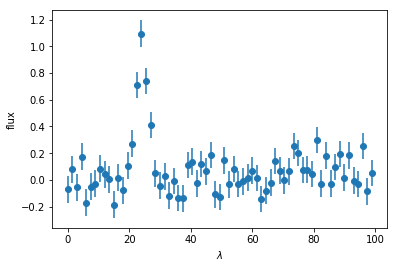

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

% matplotlib inline

df = pa.read_csv('tut_05_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

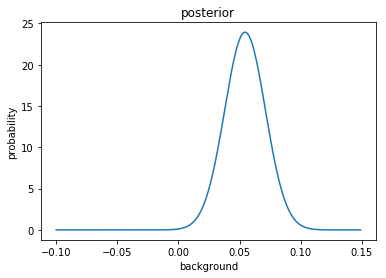

Posterior at edges of parameter space:  5.145873718776107e-18 2.52702008593455e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]
The average of posterior  : 0.05453108678141714
The variance of posterior  : 0.016666664987686954


In [7]:
import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print ('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print ('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print ('The average of posterior  :',bave)
print ('The variance of posterior  :',np.sqrt(variance))

3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

{'A': 1.0286676814391427, 'lo': 24.11716855524411, 'dl': 2.613981344498234, 'offset': 0.028616502719477233}


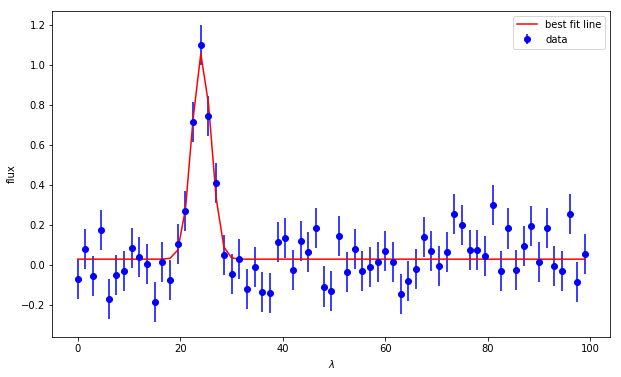

In [43]:
class line (object):
    
    def __init__ (self, parameters):
        self.A = parameters['A']
        self.lo = parameters['lo']
        self.dl = parameters['dl']
        self.offset = parameters['offset']
        
    def flux (self, lamb):
        exp_fact = -((lamb-self.lo)/self.dl)**2
        return self.A*np.exp(exp_fact) + self.offset

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

lamb = df['wavelength']
flux = df['flux']
sig = df['sigma']

def neg_loglike (parameters):
    param = {'A':parameters[0], 'lo':parameters[1], 'dl':parameters[2], 'offset':parameters[3]}
    lin = line(param)
    delta = flux - lin.flux(lamb)
    return +0.5*np.sum((delta/sig)**2)

data_offset = bave

guess_parameters = {'A':1.1, 'lo':24, 'dl':3, 'offset':0.05}

opt_par = opt.minimize (neg_loglike, [guess_parameters['A'], guess_parameters['lo'], guess_parameters['dl'], guess_parameters['offset']])

opt_parameters = {'A':opt_par.x[0], 'lo':opt_par.x[1], 'dl':opt_par.x[2], 'offset':opt_par.x[3]}
print(opt_parameters)

opt_line = line(opt_parameters)

plt.figure(figsize=(10,6))
plt.errorbar(lamb , flux, yerr=sig, fmt='o', color='blue', label='data')
plt.plot(lamb, opt_line.flux(lamb), color='red', label='best fit line')
plt.xlabel('$\lambda$')
plt.ylabel('flux')
plt.legend()
plt.show()

4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jeffreys priors on $A$.

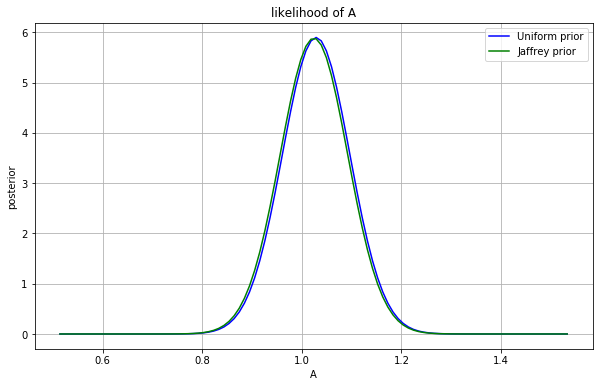

In [9]:
opt_A = opt_par.x[0]
dA = opt_A/100.
A_array = np.arange(0.5*opt_A, 1.5*opt_A, dA)
unif_likel = np.empty(len(A_array))
Jaff_likel = np.empty(len(A_array))

for i in range(len(A_array)):
    param = [A_array[i], opt_parameters['lo'], opt_parameters['dl'], opt_parameters['offset']]
    unif_likel[i] = np.exp(-neg_loglike(param))
    Jaff_likel[i] = np.exp(-neg_loglike(param))/A_array[i]

norm_unif_likel = unif_likel/(np.sum(unif_likel)*dA)
norm_Jaff_likel = Jaff_likel/(np.sum(Jaff_likel)*dA)

plt.figure(figsize=(10,6))
plt.plot(A_array, norm_unif_likel, color='blue', label='Uniform prior')
plt.plot(A_array, norm_Jaff_likel, color='green', label='Jaffrey prior')
plt.xlabel('A')
plt.ylabel('posterior')
plt.title('likelihood of A')
plt.grid()
plt.legend()
plt.show()

5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

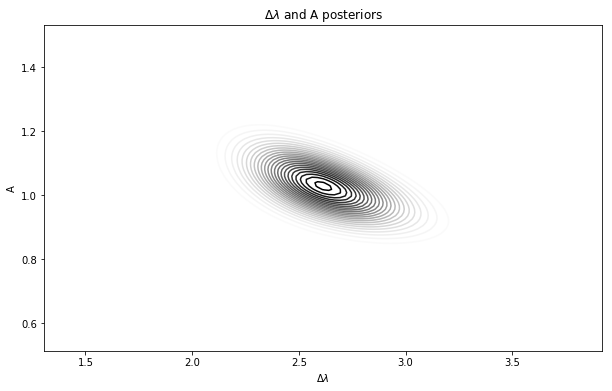

In [10]:
opt_dl = opt_par.x[2]
ddl = opt_dl/100.
dl_array = np.arange(0.5*opt_dl, 1.5*opt_dl, ddl)

N_A = len(A_array)
N_dl = len(dl_array)

likelihood = np.empty([N_A, N_dl])

for i in range(N_A):
    for j in range(N_dl):
        param = [A_array[i], opt_parameters['lo'], dl_array[j], opt_parameters['offset']]
        likelihood[i][j] = np.exp(-neg_loglike(param))

likelihood = likelihood/(np.sum(likelihood)*dA*ddl)

X,Y = np.meshgrid(dl_array, A_array)

plt.figure(figsize=(10,6))
plt.contour(X, Y, likelihood, 30, cmap='Greys')
plt.xlabel('$\Delta\lambda$')
plt.ylabel('A')
plt.title('$\Delta\lambda$ and A posteriors')
#plt.colorbar()
plt.show()

6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

Draw the contours to enclose 68%, 95% and 99% of the posterior.  To find the proper contour levels copy the function that is in the notes at the end of chapter 5.

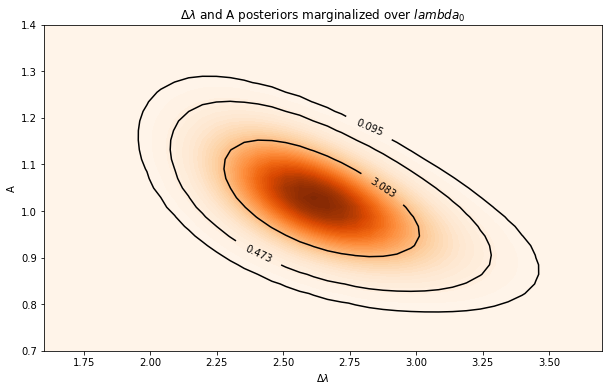

In [11]:
import scipy.integrate as integ

# This will be usefull later, in order to calculate contours levels
def find_level(posterior,fraction) :
    tot = np.sum(posterior)
    max = np.max(posterior)
    min = np.min(posterior)
    ## initialize level to halfway between max and min
    level = 0.5*(max + min)
    ## initialize fraction for this level
    frac = np.sum( posterior[ posterior >= level ] )/tot
    ## initialize resolution = +/- smallest pixel as fraction of total
    res = np.min( posterior[ posterior >= level ] )/tot
    ## iterate until frac is within res of the input fraction
    while( abs(frac - fraction) > res ) :
        ## update max or min
        if( frac > fraction) :
            min = level
        else :
            max = level
        ## update level by bisecting
        level = 0.5*(max + min)
        ## update frac and res
        frac = np.sum( posterior[ posterior >= level ] )/tot
        res = np.min( posterior[ posterior >= level ] )/tot
    ## output the level and its actual fraction
    return level, frac

#######################################################################################
approx = 50.  ##  re-defining parameters' arrays in order to limit calculation time  ##
#######################################################################################

opt_dl = opt_parameters['dl']
ddl = opt_dl/approx
dl_array = np.arange(0.5*opt_dl, 1.5*opt_dl, ddl)

opt_A = opt_parameters['A']
dA = opt_A/approx
A_array = np.arange(0.5*opt_A, 1.5*opt_A, dA)

opt_lo = opt_parameters['lo']
lo_extr = [0.5*opt_lo, 1.5*opt_lo]

# re-difining neg_loglike so that it can be used by Marginalized_posterior
def new_neg_loglike (lo, A, dl, offset = opt_parameters['offset']):
    param = {'A':A, 'lo':lo, 'dl':dl, 'offset':offset}
    lin = line(param)
    delta = flux - lin.flux(lamb)
    return -0.5*np.sum((delta/sig)**2)

# defining posterior function
def posterior (lo, A, dl):
    return np.exp(new_neg_loglike (lo, A, dl))

# defining the marginalized posterior function
def marg_post (A, dl):
    return integ.quad(posterior, lo_extr[0], lo_extr[1], args=(A, dl))[0]

N_A = len(A_array)
N_dl = len(dl_array)

likelihood = np.empty([N_A, N_dl])

for i in range(N_A):
    for j in range(N_dl):
        likelihood[i][j] = marg_post(A_array[i], dl_array[j])
        
likelihood = likelihood/(np.sum(likelihood)*dA*ddl)

X,Y = np.meshgrid(dl_array, A_array)

fraction = [0.99, 0.95, 0.68]
contour_levels = np.empty([len(fraction), len(fraction)])

for i in range(len(fraction)):
    contour_levels[i, 0], contour_levels[i, 1] = find_level(likelihood, fraction[i])

plt.figure(figsize=(10,6))
CS = plt.contour(X, Y, likelihood, levels=contour_levels[:, 0], colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.contourf(X, Y, likelihood, 50, cmap='Oranges')
plt.xlim(1.6, 3.7)
plt.ylim(0.7, 1.4)
plt.xlabel('$\Delta\lambda$')
plt.ylabel('A')
plt.title('$\Delta\lambda$ and A posteriors marginalized over $lambda_0$')
plt.show()

7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.

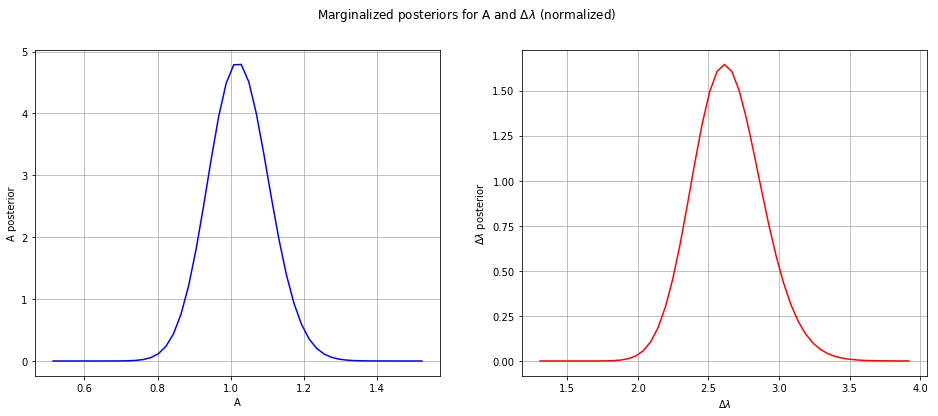

In [12]:
marg_A = np.empty([N_A])
for i in range(N_A):
    marg_A[i] = np.sum(likelihood[i,:])
marg_A = marg_A/(np.sum(marg_A)*dA)    
    
marg_dl = np.empty([N_dl])
for i in range(N_dl):
    marg_dl[i] = np.sum(likelihood[:,i])
marg_dl = marg_dl/(np.sum(marg_dl)*ddl)
    
plt.subplots(figsize=(16,6))
plt.suptitle('Marginalized posteriors for A and $\Delta\lambda$ (normalized)')

plt.subplot(121)
plt.plot(A_array, marg_A, color='blue')
plt.xlabel('A')
plt.ylabel('A posterior')
#plt.title('Marginalized posterior for A')
plt.grid()

plt.subplot(122)
plt.plot(dl_array, marg_dl, color='red')
plt.xlabel('$\Delta\lambda$')
plt.ylabel('$\Delta\lambda$ posterior')
#plt.title('Marginalized posterior for Δλ')
plt.grid()

#plt.tight_layout()
plt.show()

8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.

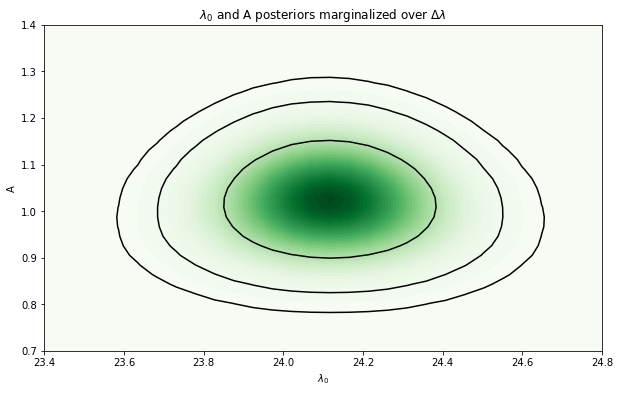

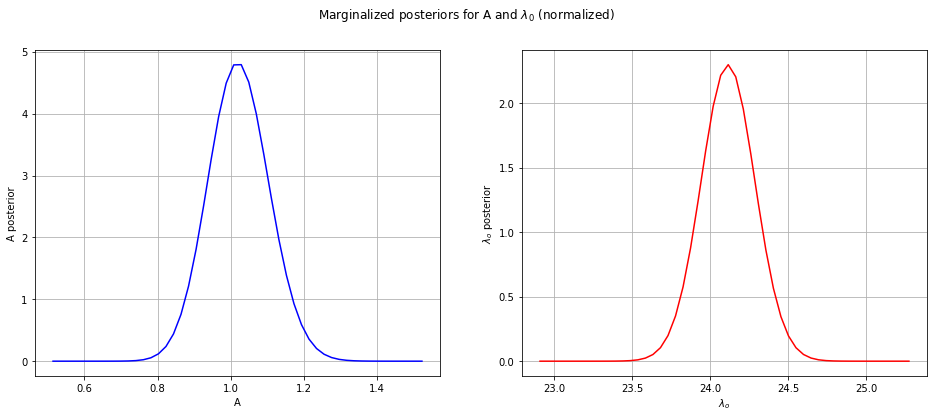

In [13]:
opt_dl = opt_parameters['dl']
dl_extr = [0.5*opt_dl, 1.5*opt_dl]

opt_A = opt_parameters['A']
dA = opt_A/approx
A_array = np.arange(0.5*opt_A, 1.5*opt_A, dA)

opt_lo = opt_parameters['lo']
dlo = opt_lo/(approx*10.)                            # the optimal value of lo is too large
lo_array = np.arange(0.95*opt_lo, 1.05*opt_lo, dlo)

# re-defining posterior function
def posterior (dl, A, lo):
    return np.exp(new_neg_loglike (lo, A, dl))

# defining the marginalized posterior function
def marg_post (A, lo):
    return integ.quad(posterior, dl_extr[0], dl_extr[1], args=(A, lo))[0]

N_A = len(A_array)
N_lo = len(lo_array)

likelihood = np.empty([N_A, N_lo])

for i in range(N_A):
    for j in range(N_lo):
        likelihood[i][j] = marg_post(A_array[i], lo_array[j])
        
likelihood = likelihood/(np.sum(likelihood)*dA*dlo)

X,Y = np.meshgrid(lo_array, A_array)

fraction = [0.99, 0.95, 0.68]
contour_levels = np.empty([len(fraction), len(fraction)])

for i in range(len(fraction)):
    contour_levels[i, 0], contour_levels[i, 1] = find_level(likelihood, fraction[i])

plt.figure(figsize=(10,6))
plt.contour(X, Y, likelihood, levels=contour_levels[:, 0], colors='black')
plt.contourf(X, Y, likelihood, 50, cmap='Greens')
plt.xlim(23.4, 24.8)
plt.ylim(0.7, 1.4)
plt.xlabel('$\lambda_0$')
plt.ylabel('A')
plt.title('$\lambda_0$ and A posteriors marginalized over $\Delta\lambda$')
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

marg_A = np.empty([N_A])
for i in range(N_A):
    marg_A[i] = np.sum(likelihood[i,:])
marg_A = marg_A/(np.sum(marg_A)*dA)    
    
marg_lo = np.empty([N_lo])
for i in range(N_lo):
    marg_lo[i] = np.sum(likelihood[:,i])
marg_lo = marg_lo/(np.sum(marg_lo)*dlo)
    
plt.subplots(figsize=(16,6))
plt.suptitle('Marginalized posteriors for A and $\lambda_0$ (normalized)')

plt.subplot(121)
plt.plot(A_array, marg_A, color='blue')
plt.xlabel('A')
plt.ylabel('A posterior')
plt.grid()

plt.subplot(122)
plt.plot(lo_array, marg_lo, color='red')
plt.xlabel('$\lambda_o$')
plt.ylabel('$\lambda_o$ posterior')
plt.grid()

plt.show()

9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

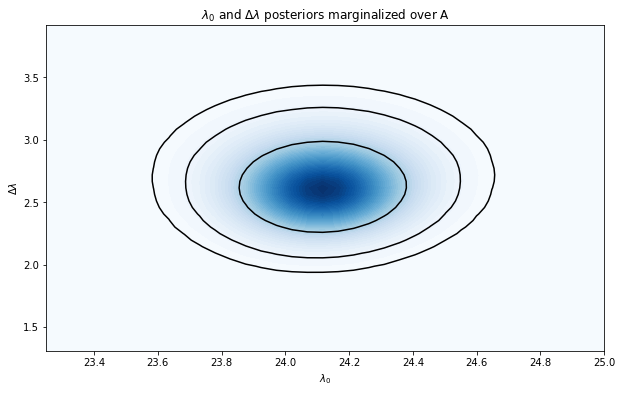

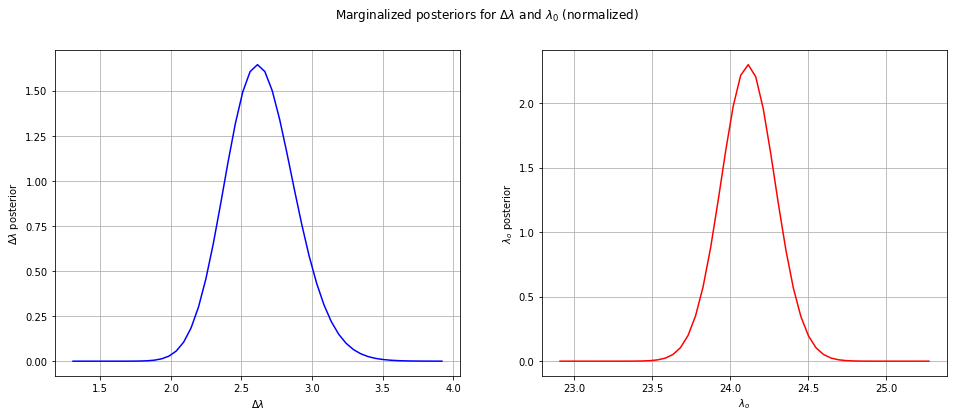

In [14]:
opt_dl = opt_parameters['dl']
ddl = opt_dl/(approx)
dl_array = np.arange(0.5*opt_dl, 1.5*opt_dl, ddl)

opt_A = opt_parameters['A']
A_extr = [0.5*opt_A, 1.5*opt_A]

opt_lo = opt_parameters['lo']
dlo = opt_lo/(approx*10.)
lo_array = np.arange(0.95*opt_lo, 1.05*opt_lo, dlo)

# re-defining posterior function
def posterior (A, dl, lo):
    return np.exp(new_neg_loglike (lo, A, dl))

# defining the marginalized posterior function
def marg_post (dl, lo):
    return integ.quad(posterior, A_extr[0], A_extr[1], args=(dl, lo))[0]

N_dl = len(dl_array)
N_lo = len(lo_array)

likelihood = np.empty([N_dl, N_lo])

for i in range(N_dl):
    for j in range(N_lo):
        likelihood[i][j] = marg_post(dl_array[i], lo_array[j])
        
likelihood = likelihood/(np.sum(likelihood)*ddl*dlo)

X,Y = np.meshgrid(lo_array, dl_array)

fraction = [0.99, 0.95, 0.68]
contour_levels = np.empty([len(fraction), len(fraction)])

for i in range(len(fraction)):
    contour_levels[i, 0], contour_levels[i, 1] = find_level(likelihood, fraction[i])

plt.figure(figsize=(10,6))
plt.contour(X, Y, likelihood, levels=contour_levels[:, 0], colors='black')
plt.contourf(X, Y, likelihood, 50, cmap='Blues')
plt.xlim(23.25, 25)
#plt.ylim(0.7, 1.4)
plt.xlabel('$\lambda_0$')
plt.ylabel('$\Delta\lambda$')
plt.title('$\lambda_0$ and $\Delta\lambda$ posteriors marginalized over A')
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

marg_dl = np.empty([N_dl])
for i in range(N_dl):
    marg_dl[i] = np.sum(likelihood[i,:])
marg_dl = marg_dl/(np.sum(marg_dl)*ddl)    
    
marg_lo = np.empty([N_lo])
for i in range(N_lo):
    marg_lo[i] = np.sum(likelihood[:,i])
marg_lo = marg_lo/(np.sum(marg_lo)*dlo)
    
plt.subplots(figsize=(16,6))
plt.suptitle('Marginalized posteriors for $\Delta\lambda$ and $\lambda_0$ (normalized)')

plt.subplot(121)
plt.plot(dl_array, marg_dl, color='blue')
plt.xlabel('$\Delta\lambda$')
plt.ylabel('$\Delta\lambda$ posterior')
plt.grid()

plt.subplot(122)
plt.plot(lo_array, marg_lo, color='red')
plt.xlabel('$\lambda_o$')
plt.ylabel('$\lambda_o$ posterior')
plt.grid()

plt.show()

10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 

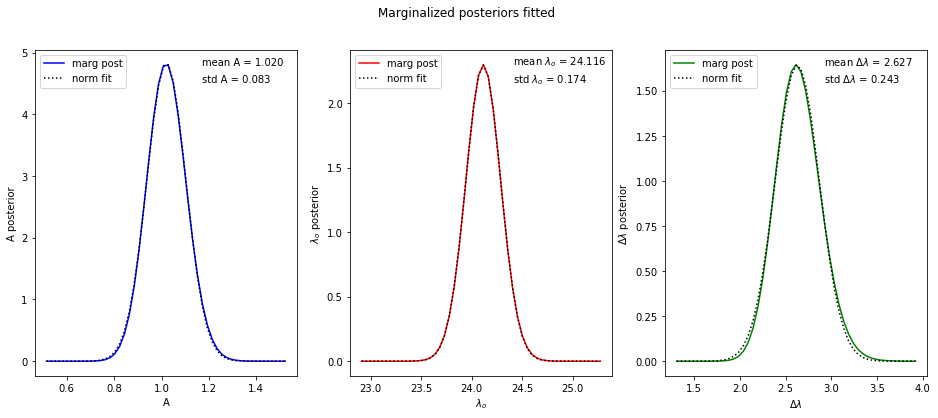

In [32]:
# There are many ways to do this: I choose maybe one of the hardest, but it is a test
# Since posteriors of A, dl and lo seems to show a normal distribution , I try to fit them with a Gaussian
import scipy.stats as ss

def normal (x, loc, scale):
    norm = 1./np.sqrt(2*np.pi*scale**2)
    return norm*np.exp(-(x-loc)**2/(2*scale**2))

def A_optimizer (par):
    loc = par[0]
    scale = par[1]
    delta = marg_A - normal(A_array, loc, scale)
    return np.sum(delta**2)

guess_A = [1., 0.2]
opt_A_par = opt.minimize(A_optimizer, guess_A).x

def lo_optimizer (par):
    loc = par[0]
    scale = par[1]
    delta = marg_lo - normal(lo_array, loc, scale)
    return np.sum(delta**2)

guess_lo = [24., 0.5]
opt_lo_par = opt.minimize(lo_optimizer, guess_lo).x

def dl_optimizer (par):
    loc = par[0]
    scale = par[1]
    delta = marg_dl - normal(dl_array, loc, scale)
    return np.sum(delta**2)

guess_dl = [2.5, 0.5]
opt_dl_par = opt.minimize(dl_optimizer, guess_dl).x

plt.subplots(figsize=(16,6))
plt.suptitle('Marginalized posteriors fitted')

plt.subplot(131)
plt.plot(A_array, marg_A, color='blue', label='marg post')
plt.plot(A_array, normal(A_array, opt_A_par[0], opt_A_par[1]), color='black', linestyle='dotted', label='norm fit')
plt.xlabel('A')
plt.ylabel('A posterior')
#plt.grid()
plt.figtext(0.27, 0.845, 'mean A = %.3f' %opt_A_par[0])
plt.figtext(0.27, 0.805, 'std A = %.3f' %abs(opt_A_par[1]))
plt.legend(loc='upper left')

plt.subplot(132)
plt.plot(lo_array, marg_lo, color='red', label='marg post')
plt.plot(lo_array, normal(lo_array, opt_lo_par[0], opt_lo_par[1]), color='black', linestyle='dotted', label='norm fit')
plt.xlabel('$\lambda_o$')
plt.ylabel('$\lambda_o$ posterior')
#plt.grid()
plt.figtext(0.54, 0.845, 'mean $\lambda_o$ = %.3f' %opt_lo_par[0])
plt.figtext(0.54, 0.805, 'std $\lambda_o$ = %.3f' %abs(opt_lo_par[1]))
plt.legend(loc='upper left')

plt.subplot(133)
plt.plot(dl_array, marg_dl, color='green', label='marg post')
plt.plot(dl_array, normal(dl_array, opt_dl_par[0], opt_dl_par[1]), color='black', linestyle='dotted', label='norm fit')
plt.xlabel('$\Delta\lambda$')
plt.ylabel('$\Delta\lambda$ posterior')
#plt.grid()
plt.figtext(0.81, 0.845, 'mean $\Delta\lambda$ = %.3f' %opt_dl_par[0])
plt.figtext(0.81, 0.805, 'std $\Delta\lambda$ = %.3f' %abs(opt_dl_par[1]))
plt.legend(loc='upper left')

plt.show()

11) Calculate the evidence for the data without the line.  Take $\lambda_o$ and $\Delta\lambda$ to be fixed to their best fit values.  Calculate the evidence for the data with the line using a uniform prior for $A$ between 0 and 1.  What is the odds for there being an emission line?

In [41]:
import scipy.special as ssp

lamb = df['wavelength']
flux = df['flux']
sig = df['sigma']

def semi_line (lamb):
    exp_fact = -((lamb-opt_parameters['lo'])/opt_parameters['dl'])**2
    return np.exp(exp_fact)+opt_parameters['offset']

def line_likel (A):
    delta = flux - A*semi_line(lamb)
    log_like = -0.5*np.sum((delta/sig)**2)
    return np.exp(log_like)

def no_line_likel (off):
    delta = flux - off
    log_like = -0.5*np.sum((delta/sig)**2)
    return np.exp(log_like)

A_min, A_max = 0.5, 1.5
off_min, off_max = -0.5, 0.5

line_evidence = 1./(A_max-A_min) * integ.quad(line_likel, A_min, A_max)[0]
no_line_evidence = 1./(off_max-off_min) * integ.quad(no_line_likel, off_min, off_max)[0]

odds = line_evidence/no_line_evidence

print('The evidence for the data with the line is %.3e, without the line is %.3e' % (line_evidence, no_line_evidence))
print('The odds for there being an emission line is %.3e' % odds)

The evidence for the data with the line is 7.116e-18, without the line is 1.715e-65
The odds for there being an emission line is 4.148e+47
